# Final Project: Sporting Game Outcome Prediction
## Data Loading and Processing

This initial section focuses on setting up the environment and defining functions to load and transform the raw play-by-play data into a usable format for game outcome prediction. We will:

* **Import Libraries:** Bring in essential libraries like pandas for data manipulation, numpy for numerical operations, matplotlib/seaborn for visualization, and various modules from scikit-learn for modeling and evaluation.
* **Define `load_and_process_data` Function:** Create a function to handle a single CSV file. This function will:
    * Read the play-by-play data.
    * Identify unique teams and attempt robust home/away team assignment (checking for `IsHome` or similar columns, falling back to approximation if needed).
    * Iterate through each game, accumulating team statistics (yards, attempts, turnovers, penalties, scores, etc.) by processing individual plays.
    * Calculate game-level differential features (e.g., `yards_diff`, `turnovers_diff`, `ypa_diff`) which often provide strong predictive signals.
    * Determine the game winner based on simplified score calculation (to be used as the target variable).
    * Return a pandas DataFrame where each row represents a single game with its aggregated stats and differentials.
* **Define `combine_data_multiple_years` Function:** Create a helper function to apply `load_and_process_data` to multiple yearly CSV files and concatenate the results into a single DataFrame.
* **Handle Warnings:** Suppress convergence and user warnings for cleaner output during potentially long computations like grid search.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler # Include both scalers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance # For non-linear feature importance
import time
import warnings

# Ignore convergence warnings for cleaner output during grid search
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Ignore potential user warnings from libraries

# Function to load and process a single year of data
def load_and_process_data(filepath):
    """
    Load and process a single year of play-by-play data.
    Aggregates statistics to the game level and calculates differentials.
    Returns a DataFrame with game-level aggregated statistics.
    """
    print(f"Loading data from {filepath}...")
    try:
        # low_memory=False can help pandas infer types correctly on mixed-type columns
        df = pd.read_csv(filepath, low_memory=False) 
        print(f" Data shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame() # Return empty DataFrame if file not found

    # Check for necessary columns early to ensure data integrity
    required_cols = ['GameId', 'OffenseTeam', 'DefenseTeam', 'Yards', 'IsRush', 'IsPass', 
                     'IsSack', 'IsInterception', 'IsFumble', 'IsPenalty', 'PenaltyTeam', 
                     'PenaltyYards', 'IsTouchdown', 'PlayType', 'Description', 'Down', 'SeriesFirstDown']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Missing required columns in {filepath}")
        missing = [col for col in required_cols if col not in df.columns]
        print(f"Missing columns: {missing}")
        return pd.DataFrame()
        
    # --- Home/Away Team Identification --- 
    # Attempt to identify home team more robustly using common column names
    home_col = None
    if 'IsHome' in df.columns:
        home_col = 'IsHome'
    # Add elif blocks here to check for other potential columns like 'HomeTeam' or 'GameLocation'
    # based on exploration of the specific dataset structure.
    
    # Group by game to create game-level features
    game_stats = {}

    # Iterate through each unique game
    for game_id in df['GameId'].unique():
        # Use .copy() to avoid SettingWithCopyWarning when modifying game_df later
        game_df = df[df['GameId'] == game_id].copy() 

        # Get unique teams involved in the game, handling potential NaN/empty strings
        teams = set(game_df['OffenseTeam'].dropna().unique()) | set(game_df['DefenseTeam'].dropna().unique())
        teams = [team for team in teams if isinstance(team, str) and team.strip()]

        # Skip processing this game if we don't have exactly 2 valid team identifiers
        if len(teams) != 2:
            continue
            
        team1, team2 = teams[0], teams[1]
        home_team, away_team = None, None

        # Determine Home/Away based on identified column or approximation
        if home_col == 'IsHome':
            # Find the first play where IsHome is defined for team1 or team2 to assign roles
            home_play = game_df[((game_df['OffenseTeam'] == team1) | (game_df['DefenseTeam'] == team1)) & game_df['IsHome'].notna()].iloc[0] if not game_df[((game_df['OffenseTeam'] == team1) | (game_df['DefenseTeam'] == team1)) & game_df['IsHome'].notna()].empty else None
            if home_play is not None:
                if home_play['IsHome'] == 1:
                    home_team, away_team = team1, team2
                else:
                    home_team, away_team = team2, team1
        
        # If robust identification failed (no suitable column found or data missing), use approximation
        if home_team is None or away_team is None:
            # This approximation assumes the first team encountered is 'home'
            home_team, away_team = team1, team2 

        # Initialize dictionaries to store aggregated stats for home and away teams
        home_stats = {
            'total_yards': 0, 'pass_yards': 0, 'rush_yards': 0,
            'pass_attempts': 0, 'rush_attempts': 0, 'turnovers': 0,
            'sacks_taken': 0, 'penalties': 0, 'penalty_yards': 0,
            'touchdowns': 0, 'field_goals': 0,
            'third_down_attempts': 0, 'third_down_conversions': 0,
            'fg_attempts': 0, 'punt_yards': 0
        }
        away_stats = home_stats.copy()

        # Calculate stats for each team by iterating through plays within the game
        for _, play in game_df.iterrows():
            off_team = play['OffenseTeam']
            # Skip plays with missing offense team identifier
            if not isinstance(off_team, str) or not off_team.strip():
                continue 

            # Determine if the current play's offense is the designated home team
            is_home_offense = (off_team == home_team)
            # Select the appropriate dictionary to update
            current_team_stats = home_stats if is_home_offense else away_stats

            # --- Accumulate Stats --- 
            # Use .get(col, 0) to safely access columns, defaulting to 0 if column or value is missing/NaN
            yards = play.get('Yards', 0)
            if pd.notna(yards):
                current_team_stats['total_yards'] += yards
                if play.get('IsRush', 0) == 1:
                    current_team_stats['rush_yards'] += yards
                    current_team_stats['rush_attempts'] += 1
                elif play.get('IsPass', 0) == 1:
                    current_team_stats['pass_yards'] += yards
                    current_team_stats['pass_attempts'] += 1
            
            # Sacks are recorded against the offense
            if play.get('IsSack', 0) == 1:
                current_team_stats['sacks_taken'] += 1
                # Ensure pass attempt is counted for sacks if not already marked as IsPass=1
                if play.get('IsPass', 0) != 1:
                     current_team_stats['pass_attempts'] += 1
            
            # Turnovers (Interceptions or Fumbles)
            if play.get('IsInterception', 0) == 1 or play.get('IsFumble', 0) == 1:
                current_team_stats['turnovers'] += 1
                
            # Penalties (only count if against the current offensive team)
            if play.get('IsPenalty', 0) == 1 and pd.notna(play.get('PenaltyTeam')) and play['PenaltyTeam'] == off_team:
                current_team_stats['penalties'] += 1
                penalty_yards = play.get('PenaltyYards', 0)
                if pd.notna(penalty_yards):
                     current_team_stats['penalty_yards'] += penalty_yards
            
            # Scoring Plays (ensure it's the offense scoring)
            if play.get('IsTouchdown', 0) == 1 and off_team == play.get('OffenseTeam'): 
                current_team_stats['touchdowns'] += 1
            if play.get('PlayType') == 'FIELD GOAL':
                current_team_stats['fg_attempts'] += 1 # Count attempt
                # Check description for success (this might need refinement based on specific data formats)
                if 'IS GOOD' in str(play.get('Description', '')).upper():
                    current_team_stats['field_goals'] += 1 # Count make
            
            # Third Down Attempts and Conversions
            if play.get('Down') == 3:
                current_team_stats['third_down_attempts'] += 1
                if play.get('SeriesFirstDown', 0) == 1: # Check if the play resulted in a first down
                    current_team_stats['third_down_conversions'] += 1
            
            # Punt Yards (assuming 'Yards' reflects net yardage, may need data validation)
            if play.get('PlayType') == 'PUNT':
                 punt_yards = play.get('Yards', 0)
                 if pd.notna(punt_yards):
                    current_team_stats['punt_yards'] += punt_yards
        
        # --- Calculate Game Outcome & Differentials --- 
        # Estimate final score (simplified: assumes 7 points for TD, 3 for FG)
        home_score = home_stats['touchdowns'] * 7 + home_stats['field_goals'] * 3 
        away_score = away_stats['touchdowns'] * 7 + away_stats['field_goals'] * 3 

        # Determine winner (target variable: 1 if home team wins, 0 otherwise)
        # Ties are treated as a loss for the home team (0) in this binary setup
        winner = 1 if home_score > away_score else 0 
        
        # Small constant to prevent division by zero in ratio calculations
        epsilon = 1e-6 

        # Calculate efficiency differentials (Home - Away)
        home_ypa = home_stats['pass_yards'] / (home_stats['pass_attempts'] + epsilon)
        away_ypa = away_stats['pass_yards'] / (away_stats['pass_attempts'] + epsilon)
        ypa_diff = home_ypa - away_ypa

        home_yra = home_stats['rush_yards'] / (home_stats['rush_attempts'] + epsilon)
        away_yra = away_stats['rush_yards'] / (away_stats['rush_attempts'] + epsilon)
        yra_diff = home_yra - away_yra

        home_3rd_conv_pct = home_stats['third_down_conversions'] / (home_stats['third_down_attempts'] + epsilon)
        away_3rd_conv_pct = away_stats['third_down_conversions'] / (away_stats['third_down_attempts'] + epsilon)
        third_down_conv_pct_diff = home_3rd_conv_pct - away_3rd_conv_pct
        
        # Calculate derived differentials (Home - Away)
        home_total_attempts = home_stats['pass_attempts'] + home_stats['rush_attempts']
        away_total_attempts = away_stats['pass_attempts'] + away_stats['rush_attempts']
        total_attempts_diff = home_total_attempts - away_total_attempts
        # Yards per play differential
        yards_per_play_diff = (home_stats['total_yards'] / (home_total_attempts + epsilon)) - \
                              (away_stats['total_yards'] / (away_total_attempts + epsilon))
        
        # Rush-to-pass ratio differential
        rush_pass_ratio_diff = (home_stats['rush_attempts'] / (home_stats['pass_attempts'] + epsilon)) - \
                               (away_stats['rush_attempts'] / (away_stats['pass_attempts'] + epsilon))

        # Create dictionary of all calculated features for the game
        # Note on differentials: Positive means home > away, except for turnovers, sacks, penalties where negative is better for home.
        feature_dict = {
            # Basic Differentials
            'yards_diff': home_stats['total_yards'] - away_stats['total_yards'],
            'pass_yards_diff': home_stats['pass_yards'] - away_stats['pass_yards'],
            'rush_yards_diff': home_stats['rush_yards'] - away_stats['rush_yards'],
            'turnovers_diff': home_stats['turnovers'] - away_stats['turnovers'], # Lower is better
            'sacks_diff': home_stats['sacks_taken'] - away_stats['sacks_taken'], # Lower is better
            'penalties_diff': home_stats['penalties'] - away_stats['penalties'], # Lower is better
            'penalty_yards_diff': home_stats['penalty_yards'] - away_stats['penalty_yards'], # Lower is better
            'pass_attempts_diff': home_stats['pass_attempts'] - away_stats['pass_attempts'],
            'rush_attempts_diff': home_stats['rush_attempts'] - away_stats['rush_attempts'],
            # Derived & Efficiency Differentials
            'yards_per_play_diff': yards_per_play_diff,
            'rush_pass_ratio_diff': rush_pass_ratio_diff,
            'ypa_diff': ypa_diff, 
            'yra_diff': yra_diff, 
            'third_down_conv_pct_diff': third_down_conv_pct_diff,
            # Other/Special Teams Differentials
            'fg_attempts_diff': home_stats['fg_attempts'] - away_stats['fg_attempts'],
            'punt_yards_diff': home_stats['punt_yards'] - away_stats['punt_yards'], 
            # --- Leaky Features (Included for potential analysis but dropped before training) ---
            'touchdowns_diff': home_stats['touchdowns'] - away_stats['touchdowns'], 
            'field_goals_diff': home_stats['field_goals'] - away_stats['field_goals'], 
            'home_score': home_score,
            'away_score': away_score,
            # --- Target Variable ---
            'winner': winner 
        }

        # Store the features for this game
        game_stats[game_id] = feature_dict

    # Convert the dictionary of game stats into a DataFrame
    games_df = pd.DataFrame.from_dict(game_stats, orient='index')
    # Add GameId back as a column
    games_df.reset_index(inplace=True)
    games_df.rename(columns={'index': 'GameId'}, inplace=True)

    print(f" Extracted {len(games_df)} games from {filepath}.")
    return games_df

# Function to combine multiple years of data
def combine_data_multiple_years(filepaths):
    """
    Load and combine processed game data from multiple CSV files.
    """
    all_games_data = []
    # Process each file and append the resulting DataFrame to a list
    for filepath in filepaths:
        year_data = load_and_process_data(filepath)
        if not year_data.empty:
            all_games_data.append(year_data)
        else:
            print(f"Skipping empty DataFrame from {filepath}")

    # Combine all yearly DataFrames if any data was loaded
    if not all_games_data:
        print("No data loaded, returning empty DataFrame.")
        return pd.DataFrame()
        
    combined_data = pd.concat(all_games_data, ignore_index=True)
    print(f"\nCombined data shape: {combined_data.shape}")
    return combined_data


## Feature Engineering and Selection

This cell executes the data loading and initial feature preparation steps. It involves:

* **Specifying Data Files:** Defining the list of CSV files containing the play-by-play data (adjust this list to include all relevant years).
* **Loading Data:** Calling the previously defined functions (`load_and_process_data` or `combine_data_multiple_years`) to get the game-level DataFrame `games_df`.
* **Handling Missing/Infinite Values:** Replacing any `inf` values (which might occur from divisions in feature calculation) with `NaN`, and then filling all remaining `NaN` values with 0. This ensures the data is clean for modeling. Filling with 0 is chosen here assuming a zero difference is a reasonable default if a calculation wasn't possible (e.g., due to zero attempts).
* **Defining Feature Sets:** Explicitly listing columns that are identifiers (`GameId`), potentially leaky (features directly revealing the score or outcome like `touchdowns_diff`, `home_score`), or the target variable (`winner`).
* **Separating X and y:** Creating the feature matrix `X` by selecting all columns from `games_df` except those identified to be dropped, and creating the target vector `y` containing only the `winner` column.
* **Verification:** Printing the final list of features used for prediction, the total number of features, the class balance (proportion of home wins vs. losses) of the target variable, and performing a final check for any remaining `inf` or `NaN` values in the feature matrix `X`.

In [3]:
# Define filepaths (Update this list with all your data files)
data_filepaths = [
    'pbp-2024.csv', 
    'pbp-2020.csv',
    'pbp-2021.csv',
    'pbp-2022.csv',
    'pbp-2023.csv'
]

# Load and combine data from specified files
if len(data_filepaths) == 1:
    # If only one file, load it directly
    games_df = load_and_process_data(data_filepaths[0])
else:
    # If multiple files, use the combine function
    games_df = combine_data_multiple_years(data_filepaths)

# --- Handle Potential Infinities and NaNs --- 
# Replace infinities resulting from calculations (e.g., division by zero) with NaN
games_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any remaining NaNs. Filling with 0 assumes a zero difference is a neutral default.
# Consider more advanced imputation if NaNs are numerous or meaningful.
if games_df.isnull().any().any():
    print("\nColumns with NaNs before filling:")
    print(games_df.isnull().sum()[games_df.isnull().sum() > 0])
    games_df.fillna(0, inplace=True) # Fill NaNs with 0
else:
    print("\nNo NaNs found in the aggregated DataFrame.")

# --- Separate Features (X) and Target (y) ---
# Define leaky features - these reveal too much about the outcome and should not be used for training
leaky_features = ['touchdowns_diff', 'field_goals_diff', 'home_score', 'away_score']
# Define identifier columns to drop
identifier_cols = ['GameId']
# Combine all columns to drop from the feature set
cols_to_drop = identifier_cols + leaky_features + ['winner'] # Also drop the target 'winner'

# Define the final feature columns by taking all columns EXCEPT those to drop
# Ensure 'winner' column exists before proceeding
if 'winner' not in games_df.columns:
    print("Error: 'winner' column not found in DataFrame. Cannot proceed.")
    X, y = pd.DataFrame(), pd.Series() # Assign empty structures to prevent further errors
else:
    # Select all columns not in the drop list as features
    final_feature_cols = [col for col in games_df.columns if col not in cols_to_drop]
    X = games_df[final_feature_cols].copy()
    # Select the 'winner' column as the target variable
    y = games_df['winner'].copy()

    print("\nFeatures used for prediction:")
    print(X.columns.tolist())
    print(f"Number of features: {X.shape[1]}")

    # Check class balance of the target variable 'winner'
    print("\nClass balance (winner):")
    class_balance = y.value_counts(normalize=True)
    print(class_balance)

    # Final verification for infinities/NaNs in the feature matrix X
    print(f"\nInfinities remaining in X before split: {np.any(np.isinf(X.values))}")
    print(f"NaNs remaining in X before split: {X.isnull().values.any()}")


Loading data from pbp-2024.csv...
 Data shape: (53283, 45)
 Extracted 284 games from pbp-2024.csv.
Loading data from pbp-2020.csv...
 Data shape: (46189, 45)
 Extracted 256 games from pbp-2020.csv.
Loading data from pbp-2021.csv...
 Data shape: (42795, 45)
 Extracted 240 games from pbp-2021.csv.
Loading data from pbp-2022.csv...
 Data shape: (38598, 45)
 Extracted 218 games from pbp-2022.csv.
Loading data from pbp-2023.csv...
 Data shape: (51287, 45)
 Extracted 272 games from pbp-2023.csv.

Combined data shape: (1270, 22)

No NaNs found in the aggregated DataFrame.

Features used for prediction:
['yards_diff', 'pass_yards_diff', 'rush_yards_diff', 'turnovers_diff', 'sacks_diff', 'penalties_diff', 'penalty_yards_diff', 'pass_attempts_diff', 'rush_attempts_diff', 'yards_per_play_diff', 'rush_pass_ratio_diff', 'ypa_diff', 'yra_diff', 'third_down_conv_pct_diff', 'fg_attempts_diff', 'punt_yards_diff']
Number of features: 16

Class balance (winner):
winner
0    0.503937
1    0.496063
Name: p

## Train-Test Split and Cross-Validation Setup

This cell prepares the data for model training and evaluation by splitting it and defining a cross-validation strategy. The key steps are:

* **Check Data Validity:** Ensure the feature matrix `X` and target vector `y` are not empty before attempting the split.
* **Train-Test Split:** Divide the dataset into training (80%) and testing (20%) sets using `train_test_split`.
    * `stratify=y` is used to ensure that the proportion of winner classes (0 and 1) is approximately the same in both the training and testing sets. This is important for reliable evaluation, especially if the classes are not perfectly balanced.
    * `random_state=42` ensures that the split is the same every time the code is run, making the results reproducible.
* **Cross-Validation Strategy:** Define the cross-validation method using `StratifiedKFold`.
    * `n_splits=5` means the training data will be split into 5 folds for cross-validation during hyperparameter tuning (Grid Search).
    * `shuffle=True` randomizes the data before splitting into folds.
    * `random_state=42` ensures reproducibility of the folds.

In [4]:
# Ensure X and y are not empty before splitting
if X.empty or y.empty:
    print("\nError: Feature matrix X or target vector y is empty. Cannot perform train-test split.")
else:
    # Split data into training and testing sets (e.g., 80% train, 20% test)
    # Use stratify=y to maintain class proportions in train and test sets, crucial for classification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,      # Reserve 20% of the data for the final test set
        random_state=42,    # Ensures the split is the same each time (for reproducibility)
        stratify=y          # Preserves the percentage of samples for each class in the split
    )
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    # Set up the cross-validation strategy for hyperparameter tuning (GridSearch)
    # Stratified K-Fold maintains class proportions within each fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Using Stratified K-Fold with {cv.get_n_splits()} splits for cross-validation.")


Training set shape: (1016, 16)
Testing set shape: (254, 16)
Using Stratified K-Fold with 5 splits for cross-validation.


## SVM Pipeline and Expanded Parameter Grid Setup

This section sets up the Support Vector Machine (SVM) modeling framework using pipelines and defines an expanded parameter grid for hyperparameter tuning. The steps include:

* **Pipeline Creation:** Define two `Pipeline` objects (`pipeline_no_weights`, `pipeline_balanced`).
    * Each pipeline includes a scaler step (initially `StandardScaler`, but will be replaced by GridSearchCV) and an `SVC` (Support Vector Classifier) step.
    * `probability=True` is set to enable probability estimates needed for ROC AUC calculation.
    * `random_state=42` ensures reproducibility.
    * One pipeline uses `class_weight=None` (default), and the other uses `class_weight='balanced'` to potentially improve performance on imbalanced datasets by adjusting class weights inversely proportional to class frequencies.
    * `max_iter=10000` is added as a safeguard against potential convergence issues for complex fits, preventing the grid search from hanging indefinitely.
* **Expanded Parameter Grid (`param_grid`):** Define a list of dictionaries specifying the hyperparameters to search over using `GridSearchCV`.
    * Tests both `StandardScaler` (centers data with unit variance) and `RobustScaler` (uses median and IQR, less sensitive to outliers) for the 'scaler' step.
    * Tests both `'linear'` (for linearly separable data) and `'rbf'` (Radial Basis Function, for non-linear data) kernels for the 'svm__kernel' step.
    * Defines ranges for `'svm__C'` (regularization parameter; smaller C = stronger regularization) using `np.logspace` (logarithmic scale) for both kernels, as optimal C often spans orders of magnitude.
    * Defines ranges for `'svm__gamma'` (kernel coefficient for RBF; influences the reach of a single training example) using `np.logspace`.
* **Test Grid (Commented Out):** Includes a much smaller grid (`param_grid_test`) useful for quickly debugging the pipeline or testing the workflow without the long computation time of the full grid.
* **Grid Calculation:** Calculates and prints the total number of parameter combinations and model fits that will be performed during the grid search for transparency.

In [ ]:
# Create pipelines for SVM. 
# Using pipelines ensures that scaling is applied correctly during cross-validation.
# The 'scaler' step name matches the key in param_grid, allowing GridSearchCV to substitute scalers.

pipeline_no_weights = Pipeline([
    ('scaler', StandardScaler()), # Default scaler, will be replaced by grid search
    # Added max_iter to prevent potential infinite loops on non-converging fits
    ('svm', SVC(probability=True, random_state=42, class_weight=None, max_iter=10000)) 
])

pipeline_balanced = Pipeline([
    ('scaler', StandardScaler()), # Default scaler, will be replaced by grid search
    # Added max_iter to prevent potential infinite loops on non-converging fits
    ('svm', SVC(probability=True, random_state=42, class_weight='balanced', max_iter=10000)) 
])

# --- Expanded Parameter Grid --- 
# Define parameter ranges for GridSearchCV
# Using logspace is common for C and gamma as optimal values often span several orders of magnitude
param_grid = [
    # Grid for Linear Kernel
    {
        'scaler': [StandardScaler(), RobustScaler()], # Test both standard and robust scaling
        'svm__kernel': ['linear'],
        'svm__C': np.logspace(-2, 2, 5) # Test C values [0.01, 0.1, 1, 10, 100]
    },
    # Grid for RBF Kernel
    {
        'scaler': [StandardScaler(), RobustScaler()], # Test both standard and robust scaling
        'svm__kernel': ['rbf'],
        'svm__C': np.logspace(-2, 2, 5), # Test C values [0.01, 0.1, 1, 10, 100]
        'svm__gamma': np.logspace(-3, 1, 5) # Test gamma values [0.001, 0.01, 0.1, 1, 10]
    }
]

current_param_grid = param_grid # Use the full grid by default

print("Pipelines and Parameter Grid defined.")
print(f"Using {'Full' if current_param_grid == param_grid else 'Simplified Test'} Parameter Grid.")

# Calculate expected number of fits for the current grid to estimate runtime
n_scalers = len(current_param_grid[0]['scaler']) # Number of scalers tested
n_linear_configs = len(current_param_grid[0]['svm__C']) # Number of C values for linear
n_rbf_configs = len(current_param_grid[1]['svm__C']) * len(current_param_grid[1]['svm__gamma']) # C * gamma combinations for RBF
total_combinations = n_scalers * (n_linear_configs + n_rbf_configs) # Total combinations per pipeline
n_folds = cv.get_n_splits() # Number of cross-validation folds

print(f"Scalers to test: {n_scalers}")
print(f"Linear SVM configurations (scaler * C): {n_scalers * n_linear_configs}")
print(f"RBF SVM configurations (scaler * C * gamma): {n_scalers * n_rbf_configs}")
print(f"Total parameter combinations to check per weighting approach: {total_combinations}")
print(f"Total fits per grid search (combinations * folds): {total_combinations * n_folds}")


Pipelines and Parameter Grid defined.
Using Full Parameter Grid.
Scalers to test: 2
Linear SVM configurations (scaler * C): 10
RBF SVM configurations (scaler * C * gamma): 50
Total parameter combinations to check per weighting approach: 60
Total fits per grid search (combinations * folds): 300


## Grid Search Execution

This cell performs the hyperparameter tuning using `GridSearchCV`. It systematically evaluates different combinations of scalers, kernels, and SVM parameters defined in the `param_grid`. The process involves:

* **Data Check:** Verifying that the training data (`X_train`, `y_train`) is available and not empty, and checking for NaNs/Infs one last time.
* **Grid Search with Balanced Weights:** Running `GridSearchCV` using `pipeline_balanced`.
    * Uses the specified parameter grid (`current_param_grid`), cross-validation strategy (`cv`), and F1 scoring.
    * `n_jobs=-1` utilizes all available CPU cores for parallel processing.
    * `verbose=1` provides output during the fitting process (can increase for more detail).
    * Records the time taken for the search.
* **Grid Search with No Weights:** Running `GridSearchCV` using `pipeline_no_weights` with the same settings.
    * Records the time taken for this search.
* **Output Results:** Printing the best parameters and the corresponding best cross-validation F1 score found for both the balanced and no-weights approaches.
* **Select Best Model:** Comparing the best scores from the two approaches and selecting the overall best pipeline (`best_svm_pipeline`) based on the higher cross-validation F1 score. The training time associated with the best approach is also stored for later comparison.

In [6]:
# Check if X_train and y_train are valid before proceeding
if 'X_train' not in locals() or 'y_train' not in locals() or X_train.empty or y_train.empty:
    print("\nError: Training data (X_train, y_train) not available or empty. Cannot perform grid search.")
else:
    # Double check for NaNs/Infs right before fitting, just in case
    print(f"\nNaNs in X_train before grid search: {X_train.isnull().values.any()}")
    print(f"Infinities in X_train before grid search: {np.any(np.isinf(X_train.values))}")
    
    # --- Grid search for balanced weights --- 
    print("\nPerforming grid search with 'balanced' class weights...")
    grid_search_balanced = GridSearchCV(
        pipeline_balanced, 
        current_param_grid, # Use the currently selected grid (full or test)     
        cv=cv,           
        scoring='f1',    # Use F1 score as the evaluation metric for optimization
        n_jobs=-1,       # Use all available CPU cores
        verbose=1        # Show some progress updates (can increase to 2 for more detail)
    )
    
    start_time_balanced = time.time()
    grid_search_balanced.fit(X_train, y_train)
    grid_search_time_balanced = time.time() - start_time_balanced
    print(f"Grid search (balanced) completed in {grid_search_time_balanced:.2f} seconds.")
    
    # --- Grid search with NO class weights --- 
    print("\nPerforming grid search with NO class weights...")
    grid_search_no_weights = GridSearchCV(
        pipeline_no_weights, 
        current_param_grid, # Use the currently selected grid (full or test)
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1        # Show some progress updates
    )
    start_time_nw = time.time()
    grid_search_no_weights.fit(X_train, y_train)
    grid_search_time_no_weights = time.time() - start_time_nw
    print(f"Grid search (no weights) completed in {grid_search_time_no_weights:.2f} seconds.")
    
    # --- Output Best Results --- 
    print(f"\n--- Results (Balanced Weights) ---")
    print(f"Best parameters: {grid_search_balanced.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search_balanced.best_score_:.4f}")
    
    print(f"\n--- Results (No Weights) ---")
    print(f"Best parameters: {grid_search_no_weights.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search_no_weights.best_score_:.4f}")
    
    # --- Select the Overall Best Model --- 
    # Choose the pipeline (balanced or no weights) that yielded the best CV F1 score
    if grid_search_no_weights.best_score_ >= grid_search_balanced.best_score_:
        print("\nSelecting best model from 'No weights' grid search.")
        best_svm_pipeline = grid_search_no_weights.best_estimator_
        best_overall_score = grid_search_no_weights.best_score_
        grid_search_time = grid_search_time_no_weights # Store time for comparison
    else:
        print("\nSelecting best model from 'Balanced weights' grid search.")
        best_svm_pipeline = grid_search_balanced.best_estimator_
        best_overall_score = grid_search_balanced.best_score_
        grid_search_time = grid_search_time_balanced # Store time for comparison
        
    print(f"Overall best cross-validation F1 score: {best_overall_score:.4f}")
    # Print the full pipeline details of the selected best model
    print(f"\nSelected best pipeline for evaluation: \n{best_svm_pipeline}")



NaNs in X_train before grid search: False
Infinities in X_train before grid search: False

Performing grid search with 'balanced' class weights...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Grid search (balanced) completed in 9.82 seconds.

Performing grid search with NO class weights...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Grid search (no weights) completed in 5.04 seconds.

--- Results (Balanced Weights) ---
Best parameters: {'scaler': StandardScaler(), 'svm__C': np.float64(0.1), 'svm__kernel': 'linear'}
Best cross-validation F1 score: 0.7678

--- Results (No Weights) ---
Best parameters: {'scaler': StandardScaler(), 'svm__C': np.float64(1.0), 'svm__kernel': 'linear'}
Best cross-validation F1 score: 0.7681

Selecting best model from 'No weights' grid search.
Overall best cross-validation F1 score: 0.7681

Selected best pipeline for evaluation: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(C=np.

## Final Model Evaluation on Test Set

After identifying the best hyperparameters through grid search and cross-validation, this cell evaluates the performance of the final, optimized SVM pipeline (`best_svm_pipeline`) on the held-out test set (`X_test`, `y_test`). This provides an unbiased estimate of the model's generalization ability on unseen data. The steps are:

* **Data Check:** Ensure the best pipeline and test data are available.
* **Prediction:** Use the best pipeline to make predictions (`y_pred_test`) and predict probabilities (`y_prob_test`) on the test set.
* **Calculate Metrics:** Compute various standard classification metrics:
    * Accuracy
    * Confusion Matrix (visualized with a heatmap)
    * Sensitivity (Recall / True Positive Rate)
    * Specificity (True Negative Rate)
    * Precision
    * F1 Score
    * Full Classification Report (includes precision, recall, f1-score per class)
    * ROC AUC Score
* **Plot ROC Curve:** Visualize the trade-off between the True Positive Rate and False Positive Rate for the final model on the test set.
* **Save Plots:** Save the generated confusion matrix and ROC curve plots as image files.


Evaluating final selected model on the test set...

Test Set Accuracy: 0.7559

Test Set Confusion Matrix:


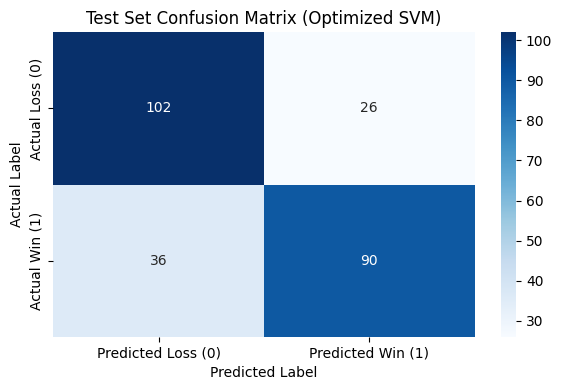


Test Set Detailed Metrics:
Sensitivity (Recall / True Positive Rate): 0.7143
Specificity (True Negative Rate): 0.7969
Precision: 0.7759
F1 Score: 0.7438

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       128
           1       0.78      0.71      0.74       126

    accuracy                           0.76       254
   macro avg       0.76      0.76      0.76       254
weighted avg       0.76      0.76      0.76       254


Test Set ROC AUC Score: 0.8117


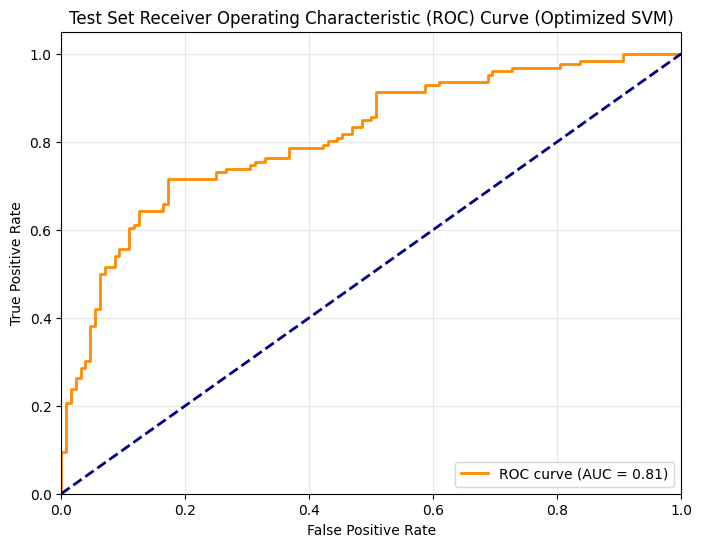

In [7]:
# Evaluate the overall best pipeline on the held-out test set

# Check if best_svm_pipeline exists and test data is valid
if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Grid search might have failed or not run.")
elif 'X_test' not in locals() or 'y_test' not in locals() or X_test.empty or y_test.empty:
     print("\nError: Test data (X_test, y_test) not available or empty. Cannot evaluate model.")
else:
    print("\nEvaluating final selected model on the test set...")
    # Predict class labels
    y_pred_test = best_svm_pipeline.predict(X_test)
    # Predict probabilities for the positive class (needed for ROC AUC)
    y_prob_test = best_svm_pipeline.predict_proba(X_test)[:, 1] 
    
    # --- Print Evaluation Metrics --- 
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
    
    print("\nTest Set Confusion Matrix:")
    cm_test = confusion_matrix(y_test, y_pred_test)
    # Plot confusion matrix for better visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Loss (0)', 'Predicted Win (1)'], 
                yticklabels=['Actual Loss (0)', 'Actual Win (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Test Set Confusion Matrix (Optimized SVM)')
    plt.tight_layout()
    plt.savefig('svm_test_confusion_matrix.png') # Save the plot
    plt.show()
    
    # Calculate detailed metrics from confusion matrix elements
    tn, fp, fn, tp = cm_test.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Same as Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print("\nTest Set Detailed Metrics:")
    print(f"Sensitivity (Recall / True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nTest Set Classification Report:")
    # Use zero_division=0 to prevent warnings if a class has no predictions
    print(classification_report(y_test, y_pred_test, zero_division=0))
    
    # --- ROC AUC Score and Curve --- 
    roc_auc_test = roc_auc_score(y_test, y_prob_test)
    print(f"\nTest Set ROC AUC Score: {roc_auc_test:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set Receiver Operating Characteristic (ROC) Curve (Optimized SVM)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('svm_test_roc_curve.png') # Save the plot
    plt.show()


## Feature Importance Analysis

This section analyzes which features were most influential for the best SVM model's predictions. The approach depends on the kernel type determined by the grid search:

* **Check Kernel Type:** Identify the kernel (`linear` or `rbf`) used by the `best_svm_pipeline`.
* **Linear Kernel:**
    * If the kernel is linear, extract the model coefficients (`.coef_`). Coefficients represent the weight assigned to each feature; larger absolute values indicate higher importance for the linear separation.
    * Create a DataFrame showing each feature and its corresponding coefficient.
    * Rank features by the absolute value of their coefficients.
    * Plot the top 10 most important features based on absolute coefficient values.
* **Non-Linear Kernel (e.g., RBF):**
    * If the kernel is non-linear, coefficients are not directly interpretable in the original feature space.
    * Calculate feature importance using `permutation_importance` on the test set. This method measures the decrease in model score (F1 score, in this case) when a single feature's values are randomly shuffled across multiple repeats.
    * Organize the mean importance scores and standard deviations into a DataFrame.
    * Plot the top 10 most important features based on mean permutation importance, including error bars representing the standard deviation across repeats.
* **Save Plot:** Save the generated feature importance plot.


Best model kernel type: linear
Calculating feature importance using Linear SVM coefficients...

Feature Importance (Top 10 based on Linear SVM Coefficients):
                     Feature  Coefficient  Abs_Coefficient
11                  ypa_diff     0.791423         0.791423
0                 yards_diff     0.594845         0.594845
9        yards_per_play_diff    -0.532556         0.532556
3             turnovers_diff    -0.484348         0.484348
7         pass_attempts_diff    -0.412467         0.412467
2            rush_yards_diff     0.239164         0.239164
13  third_down_conv_pct_diff     0.196125         0.196125
1            pass_yards_diff     0.164645         0.164645
4                 sacks_diff    -0.154498         0.154498
6         penalty_yards_diff     0.149384         0.149384


C:\Users\User\AppData\Local\Temp\ipykernel_10972\1506389663.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df.head(10), palette='viridis')


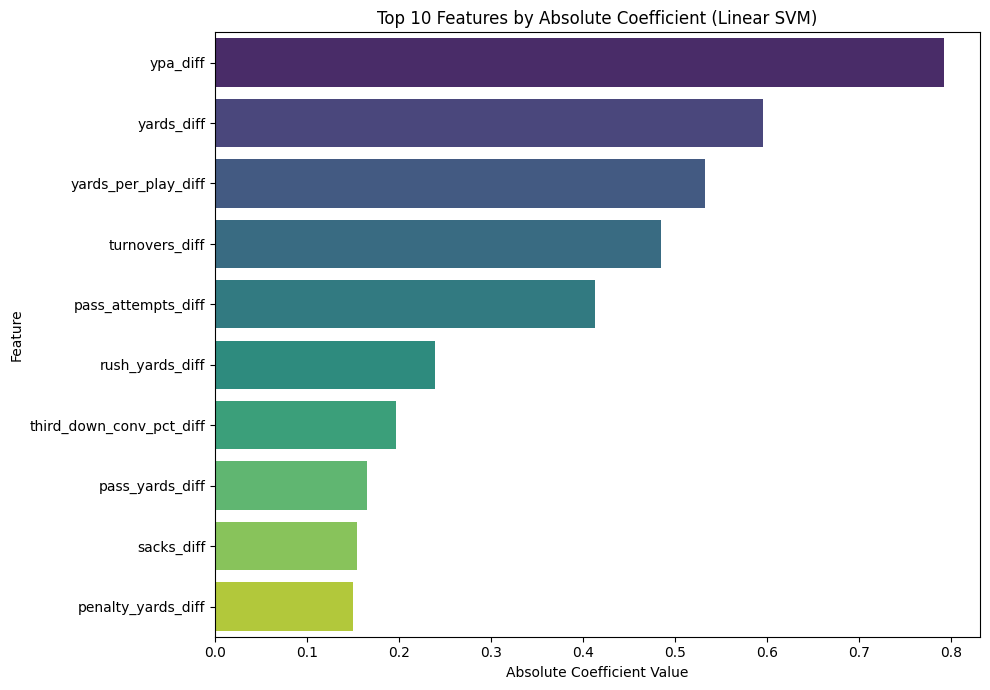

In [8]:
# --- Feature Importance --- 
# Determine feature importance based on the best model's kernel type

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot determine feature importance.")
elif 'X_train' not in locals() or 'X_test' not in locals(): # Check if X_train/X_test exist
     print("\nError: Training or Test data not available. Cannot determine feature importance.")
else:
    # Get the SVM step from the best pipeline
    best_svm_model = best_svm_pipeline.named_steps['svm']
    best_kernel = best_svm_model.kernel
    print(f"\nBest model kernel type: {best_kernel}")

    if best_kernel == 'linear':
        print("Calculating feature importance using Linear SVM coefficients...")
        # For linear SVM, coefficients indicate feature importance
        coefficients = best_svm_model.coef_[0]
        
        # Create DataFrame to display feature names and coefficients
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns, # Get feature names from training data
            'Coefficient': coefficients
        })
        # Use absolute coefficient value to rank importance regardless of direction
        feature_importance_df['Abs_Coefficient'] = abs(feature_importance_df['Coefficient'])
        # Sort features by importance (descending)
        feature_importance_df = feature_importance_df.sort_values('Abs_Coefficient', ascending=False)
        
        print("\nFeature Importance (Top 10 based on Linear SVM Coefficients):")
        print(feature_importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df.head(10), palette='viridis')
        plt.title('Top 10 Features by Absolute Coefficient (Linear SVM)')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig('svm_linear_feature_importance.png')
        plt.show()

    else: # For non-linear kernels like 'rbf'
        print("\nCalculating feature importance using Permutation Importance (on test set)...")
        # Permutation importance is suitable for non-linear models
        # It assesses importance by measuring performance drop when a feature is shuffled
        perm_importance = permutation_importance(
            best_svm_pipeline, # Use the entire pipeline (includes scaling)
            X_test, 
            y_test, 
            n_repeats=30,       # Increase repeats for more stable estimates
            random_state=42,
            scoring='f1',       # Use the primary evaluation metric
            n_jobs=-1
        )
        
        # Organize results into a DataFrame
        sorted_idx = perm_importance.importances_mean.argsort()[::-1] # Sort descending by mean importance
        feature_importance_df = pd.DataFrame({
            'Feature': X_test.columns[sorted_idx],
            'Importance': perm_importance.importances_mean[sorted_idx],
            'Std Dev': perm_importance.importances_std[sorted_idx]
        })
        
        print("\nFeature Importance (Top 10 based on Permutation Importance):")
        print(feature_importance_df.head(10))
        
        # Plot permutation importance with error bars
        plt.figure(figsize=(10, 7))
        ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), 
                    palette='viridis')
        # Add error bars using calculated standard deviation
        ax.errorbar(x=feature_importance_df['Importance'].head(10), 
                    y=np.arange(10), 
                    xerr=feature_importance_df['Std Dev'].head(10), 
                    fmt='none', c='black', capsize=3)
        plt.title(f'Top 10 Features by Permutation Importance ({best_kernel.upper()} SVM)')
        plt.xlabel('Mean Importance (F1 Score Decrease)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(f'svm_{best_kernel}_feature_importance.png')
        plt.show()


## Cross-Validation and Baseline Comparison

This section provides further evaluation and context for the optimized SVM model. It includes:

* **Cross-Validation on Full Dataset:**
    * Performs k-fold cross-validation (using the same `StratifiedKFold` strategy as the grid search) on the *entire* dataset (`X`, `y`) using the `best_svm_pipeline`.
    * Calculates the F1 score for each fold.
    * Reports the mean and standard deviation of the cross-validation F1 scores. This gives an estimate of the model's stability and expected performance on different subsets of the data.
* **Baseline Model Comparison:**
    * Defines two baseline SVM models within pipelines: one with a linear kernel and default parameters, and one with an RBF kernel and default parameters (both using `StandardScaler`).
    * Trains these baseline models on the training set (`X_train`, `y_train`).
    * Evaluates the baselines on the test set (`X_test`, `y_test`), calculating Accuracy, F1 Score, Precision, Recall, and Training Time.
    * Combines the results of the baseline models and the previously evaluated `Optimized SVM` into a DataFrame.
    * Prints the comparison table.
    * Generates bar plots comparing the performance metrics (Accuracy, F1, Precision, Recall) and the training times of the optimized model versus the baselines.
    * Saves the comparison plots.


Performing cross-validation on the full dataset with the best pipeline...

Cross-validation F1 scores for each fold: [0.75384615 0.7265625  0.73029046 0.76744186 0.77911647]
Mean CV F1 score: 0.7515 ± 0.0205

Comparing with baseline models (untuned, default parameters)...

Training Baseline Linear SVM...
Evaluating Baseline Linear SVM on test set...

Training Baseline RBF SVM...
Evaluating Baseline RBF SVM on test set...

--- Model Comparison Table ---
                     Accuracy  F1 Score  Precision    Recall  \
Baseline Linear SVM  0.755906  0.755450   0.757352  0.755906   
Baseline RBF SVM     0.744094  0.743526   0.745766  0.744094   
Optimized SVM        0.755906  0.743802   0.775862  0.714286   

                     Training Time (s)  
Baseline Linear SVM           0.178540  
Baseline RBF SVM              0.151478  
Optimized SVM                 5.036275  


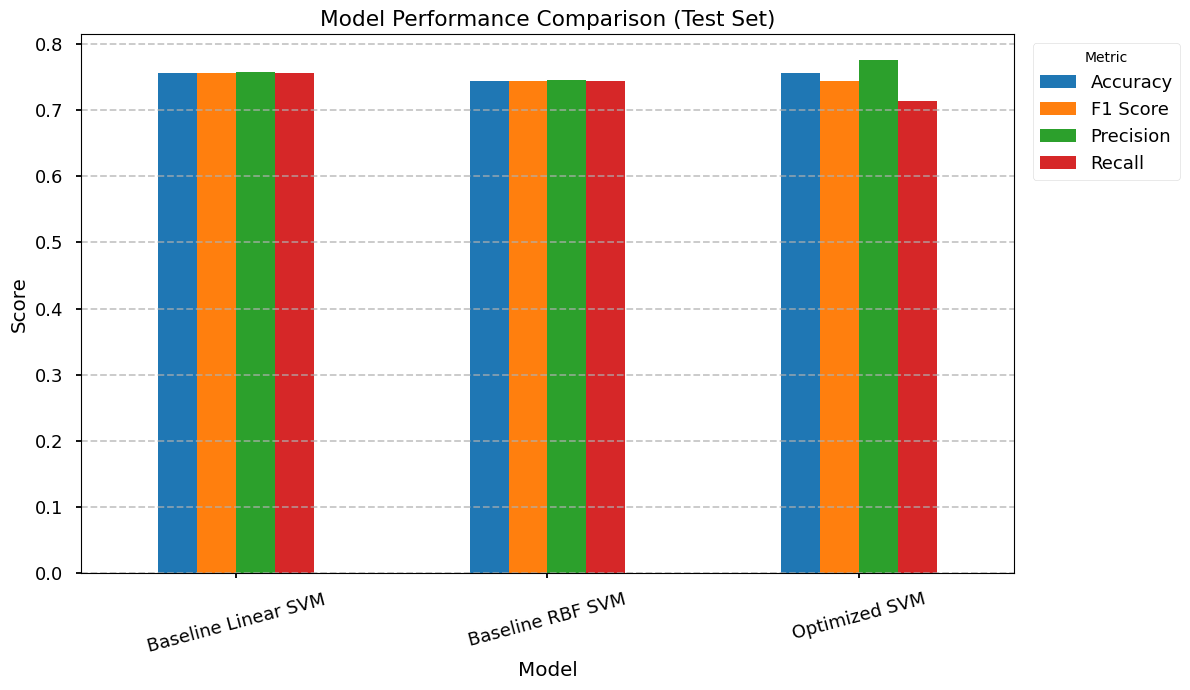

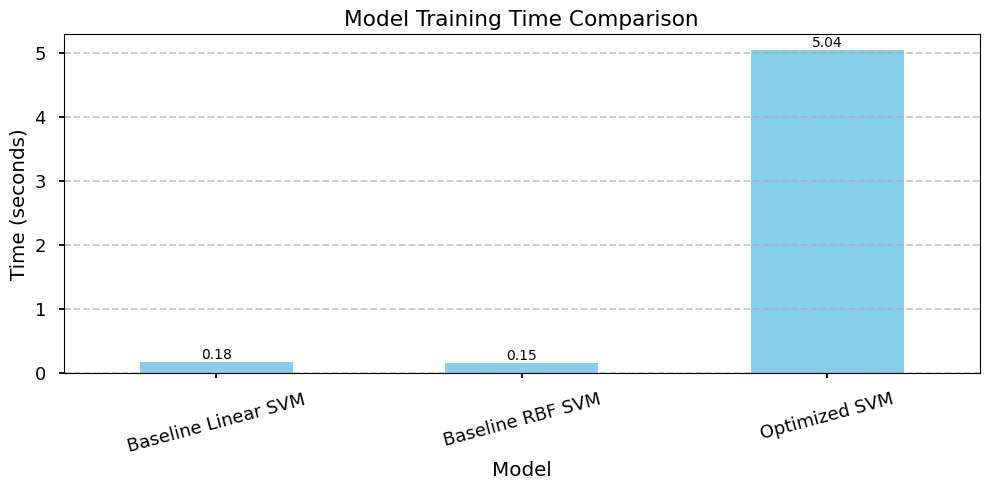

In [9]:
# --- Cross-validation for Reliability Estimation --- 
# Perform cross-validation on the *entire* dataset using the *best found pipeline*
# This gives an estimate of how the model might perform on average on new, unseen data splits

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot perform cross-validation.")
elif X.empty or y.empty:
     print("\nError: Full dataset (X, y) not available or empty. Cannot perform cross-validation.")
else:
    print("\nPerforming cross-validation on the full dataset with the best pipeline...")
    # Use the same CV strategy as in grid search for consistency
    cv_scores = cross_val_score(best_svm_pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1)
    print(f"\nCross-validation F1 scores for each fold: {cv_scores}")
    print(f"Mean CV F1 score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- Compare with Baseline Models --- 
print("\nComparing with baseline models (untuned, default parameters)...")

# Define Baseline Linear SVM (using default C=1)
baseline_linear = Pipeline([
    ('scaler', StandardScaler()), # Use standard scaler for baseline consistency
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

# Define Baseline RBF SVM (using default C=1, gamma='scale')
baseline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# Dictionary to store results for comparison
baseline_results = {}
baseline_models = {
    'Baseline Linear SVM': baseline_linear,
    'Baseline RBF SVM': baseline_rbf
}

# Check if training and test data are valid before proceeding
if 'X_train' not in locals() or 'y_train' not in locals() or X_train.empty or y_train.empty:
    print("\nError: Training data not available. Cannot train baseline models.")
elif 'X_test' not in locals() or 'y_test' not in locals() or X_test.empty or y_test.empty:
    print("\nError: Test data not available. Cannot evaluate baseline models.")
else:
    # Train and evaluate baseline models
    for name, model in baseline_models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        print(f"Evaluating {name} on test set...")
        y_pred_base = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_base)
        # Get classification report as dict, handle potential zero division
        report = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
        
        # Store key metrics
        baseline_results[name] = {
            'Accuracy': accuracy,
            'F1 Score': report['weighted avg']['f1-score'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'Training Time (s)': train_time
        }

    # Add the optimized model's results (calculated previously) for direct comparison
    if 'best_svm_pipeline' in locals() and 'test_accuracy' in locals():
        baseline_results['Optimized SVM'] = {
            'Accuracy': test_accuracy, 
            'F1 Score': f1, 
            'Precision': precision, 
            'Recall': sensitivity, 
            'Training Time (s)': grid_search_time # Use the stored time for the best grid search run
        }
    
    # Convert results dictionary to DataFrame for display
    results_comparison_df = pd.DataFrame(baseline_results).T
    print("\n--- Model Comparison Table ---")
    print(results_comparison_df)
    
    # --- Plotting Comparisons --- 
    plt.style.use('seaborn-v0_8-talk') # Use a presentation-friendly style

    # Plot performance metrics comparison
    fig_perf, ax_perf = plt.subplots(figsize=(12, 7))
    results_comparison_df[['Accuracy', 'F1 Score', 'Precision', 'Recall']].plot(kind='bar', ax=ax_perf)
    ax_perf.set_title('Model Performance Comparison (Test Set)')
    ax_perf.set_ylabel('Score')
    ax_perf.set_xlabel('Model')
    ax_perf.tick_params(axis='x', rotation=15)
    ax_perf.legend(title='Metric', bbox_to_anchor=(1.01, 1), loc='upper left')
    ax_perf.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('svm_model_comparison_performance.png')
    plt.show()
    
    # Plot training time comparison
    fig_time, ax_time = plt.subplots(figsize=(10, 5))
    results_comparison_df[['Training Time (s)']].plot(kind='bar', ax=ax_time, legend=False, color='skyblue')
    ax_time.set_title('Model Training Time Comparison')
    ax_time.set_ylabel('Time (seconds)')
    ax_time.set_xlabel('Model')
    ax_time.tick_params(axis='x', rotation=15)
    ax_time.grid(axis='y', linestyle='--', alpha=0.7)
    # Add value labels to bars for clarity
    for container in ax_time.containers:
        ax_time.bar_label(container, fmt='%.2f')
    plt.tight_layout()
    plt.savefig('svm_model_comparison_time.png')
    plt.show()


## Second Machine Learning Technique: [Your Second Model Name - e.g., Neural Network (MLP)]

*(Project Requirement: Implement and evaluate at least two ML techniques)*

This section implements and evaluates the second chosen machine learning technique for comparison with the SVM.

* **Setup:** Define the pipeline (including scaling) and parameter grid for the second model (e.g., MLPClassifier).
* **Hyperparameter Tuning:** Use `GridSearchCV` with the same cross-validation strategy (`cv`) and scoring metric (`f1`) to find the best hyperparameters for this model.
* **Evaluation:** Evaluate the best version of this second model on the held-out test set (`X_test`, `y_test`), calculating the same set of metrics (Accuracy, CM, Precision, Recall, F1, ROC AUC) as used for the SVM.
* **Feature Importance (If Applicable):** Calculate and visualize feature importance using an appropriate method for the chosen model (e.g., permutation importance).
* **Learning Curve:** Generate a learning curve for the optimized second model.
* **Add to Comparison:** Add the results (performance metrics, training time) of this optimized second model to the `results_comparison_df` DataFrame and regenerate the comparison plots.


--- Implementing Second Technique: MLP Classifier ---

Performing grid search for MLP Classifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Grid search (MLP) completed in 45.70 seconds.
Best MLP parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam', 'scaler': RobustScaler()}
Best cross-validation F1 score (MLP): 0.7575

Evaluating best MLP model on the test set...
MLP Test Accuracy: 0.7087
MLP Test F1 Score: 0.7081
MLP Test Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       128
           1       0.72      0.67      0.69       126

    accuracy                           0.71       254
   macro avg       0.71      0.71      0.71       254
weighted avg       0.71      0.71      0.71       254


--- Updated Model Comparison Table ---
                     Accuracy  F1 Score  Precision    Recall  \
Baseline Linear SVM  0.755906  0

C:\Users\User\AppData\Local\Temp\ipykernel_10972\2675890153.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_mlp_df.head(10),


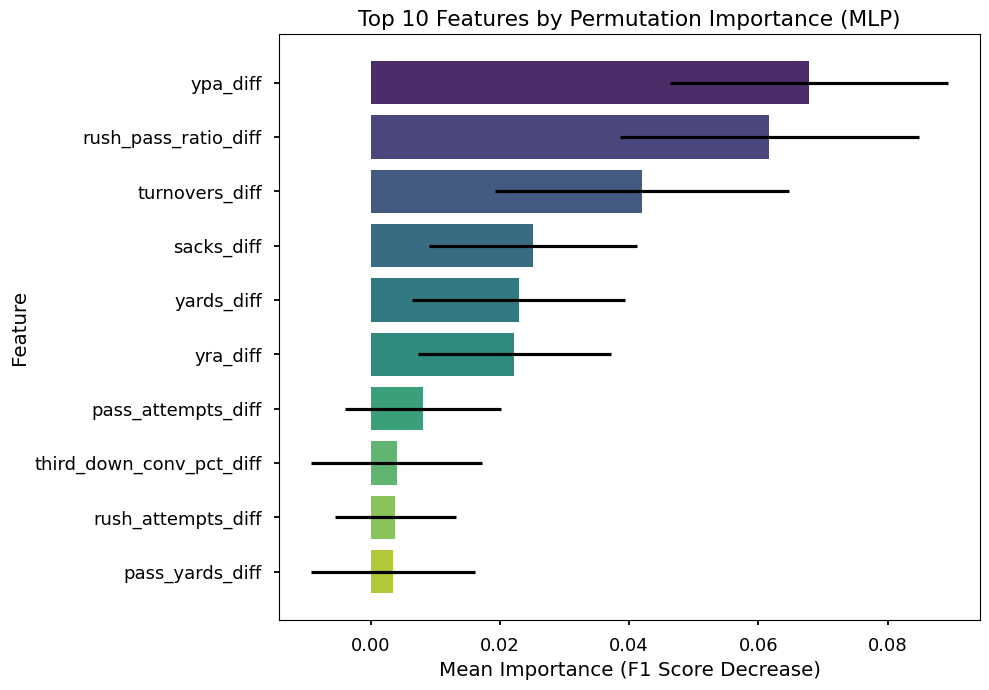


Generating learning curve for MLP...


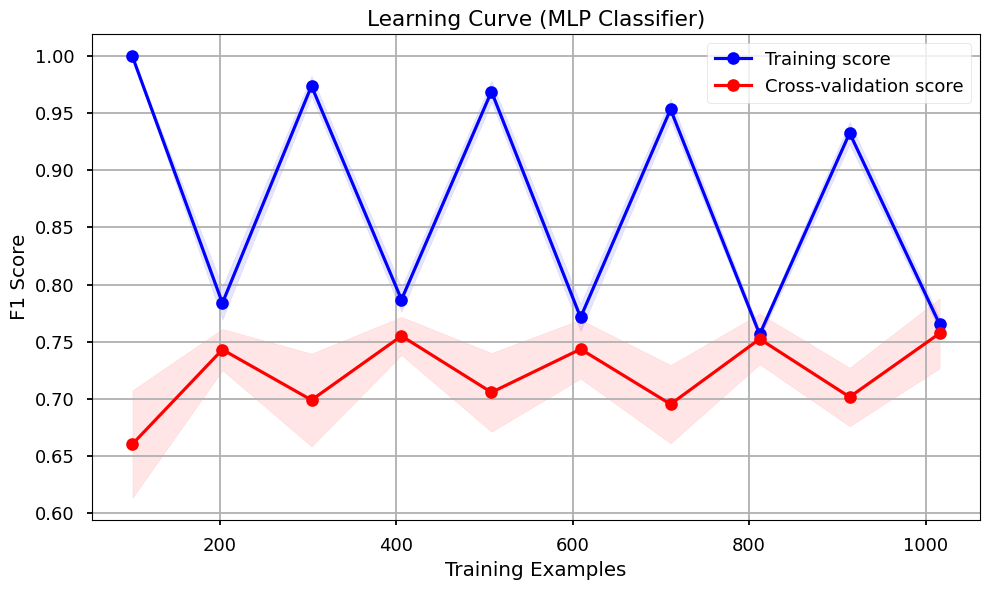

In [10]:
# Placeholder for implementing and evaluating the second ML technique
# Example using MLPClassifier (as potentially proposed)
from sklearn.neural_network import MLPClassifier

print("\n--- Implementing Second Technique: MLP Classifier ---")

# 1. Define Pipeline for MLP
pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()), # Or RobustScaler, can be tuned
    ('mlp', MLPClassifier(random_state=42, max_iter=1000)) # Increased max_iter
])

# 2. Define Parameter Grid for MLP (Example)
param_grid_mlp = {
    'scaler': [StandardScaler(), RobustScaler()],
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)], # Example architectures
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'], # Adam is often a good default
    'mlp__alpha': [0.0001, 0.001, 0.01] # Regularization
}

# 3. Perform GridSearchCV for MLP
print("\nPerforming grid search for MLP Classifier...")
grid_search_mlp = GridSearchCV(
    pipeline_mlp,
    param_grid_mlp,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time_mlp = time.time()
# Ensure training data is available
if 'X_train' in locals() and not X_train.empty:
    grid_search_mlp.fit(X_train, y_train)
    grid_search_time_mlp = time.time() - start_time_mlp
    print(f"Grid search (MLP) completed in {grid_search_time_mlp:.2f} seconds.")
    print(f"Best MLP parameters: {grid_search_mlp.best_params_}")
    print(f"Best cross-validation F1 score (MLP): {grid_search_mlp.best_score_:.4f}")
    best_mlp_pipeline = grid_search_mlp.best_estimator_

    # 4. Evaluate Best MLP on Test Set
    print("\nEvaluating best MLP model on the test set...")
    y_pred_mlp_test = best_mlp_pipeline.predict(X_test)
    # y_prob_mlp_test = best_mlp_pipeline.predict_proba(X_test)[:, 1] # If needed for ROC
    
    mlp_accuracy = accuracy_score(y_test, y_pred_mlp_test)
    mlp_report = classification_report(y_test, y_pred_mlp_test, output_dict=True, zero_division=0)
    mlp_f1 = mlp_report['weighted avg']['f1-score']
    mlp_precision = mlp_report['weighted avg']['precision']
    mlp_recall = mlp_report['weighted avg']['recall']

    print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
    print(f"MLP Test F1 Score: {mlp_f1:.4f}")
    print("MLP Test Classification Report:")
    print(classification_report(y_test, y_pred_mlp_test, zero_division=0))
    
    # 5. Add MLP results to the comparison DataFrame (if it exists)
    if 'results_comparison_df' in locals():
        results_comparison_df.loc['Optimized MLP'] = {
            'Accuracy': mlp_accuracy,
            'F1 Score': mlp_f1,
            'Precision': mlp_precision,
            'Recall': mlp_recall,
            'Training Time (s)': grid_search_time_mlp
        }
        print("\n--- Updated Model Comparison Table ---")
        print(results_comparison_df)
        
        # Regenerate comparison plots if needed
        # ... (plotting code similar to the end of the SVM baseline comparison cell) ...
    else:
        print("Comparison DataFrame not found, skipping update.")

else:
    print("\nSkipping MLP implementation due to missing training data.")

# Feature Importance for MLP using Permutation Importance
if 'best_mlp_pipeline' in locals() and 'X_test' in locals() and not X_test.empty:
    print("\nCalculating feature importance for MLP using Permutation Importance...")
    
    # Calculate permutation importance on test set
    perm_importance_mlp = permutation_importance(
        best_mlp_pipeline,
        X_test, 
        y_test, 
        n_repeats=30,
        random_state=42,
        scoring='f1',
        n_jobs=-1
    )
    
    # Organize results into DataFrame
    sorted_idx_mlp = perm_importance_mlp.importances_mean.argsort()[::-1]
    feature_importance_mlp_df = pd.DataFrame({
        'Feature': X_test.columns[sorted_idx_mlp],
        'Importance': perm_importance_mlp.importances_mean[sorted_idx_mlp],
        'Std Dev': perm_importance_mlp.importances_std[sorted_idx_mlp]
    })
    
    print("\nMLP Feature Importance (Top 10):")
    print(feature_importance_mlp_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_mlp_df.head(10), 
                palette='viridis')
    # Add error bars
    ax.errorbar(x=feature_importance_mlp_df['Importance'].head(10), 
                y=np.arange(10), 
                xerr=feature_importance_mlp_df['Std Dev'].head(10), 
                fmt='none', c='black', capsize=3)
    plt.title('Top 10 Features by Permutation Importance (MLP)')
    plt.xlabel('Mean Importance (F1 Score Decrease)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('mlp_feature_importance.png')
    plt.show()

    # Learning Curve for MLP
    print("\nGenerating learning curve for MLP...")
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        best_mlp_pipeline,
        X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    
    # Calculate statistics
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-validation score')
    
    # Add standard deviation bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.title('Learning Curve (MLP Classifier)')
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('mlp_learning_curve.png')
    plt.show()
else:
    print("Cannot generate MLP feature importance or learning curve - model or test data not available.")


## Learning Curve Analysis

This cell generates a learning curve for the best SVM pipeline identified by the grid search. Learning curves help diagnose model performance issues related to bias and variance, and indicate whether collecting more data might be beneficial. The steps are:

* **Data Check:** Ensure the best pipeline and the full dataset (`X`, `y`) are available.
* **Generate Learning Curve Data:** Use the `learning_curve` function from scikit-learn.
    * Pass the `best_svm_pipeline`, the full dataset (`X`, `y`), and the cross-validation strategy (`cv`).
    * Specify `train_sizes` (e.g., 10 points from 10% to 100% of the training data) to evaluate performance on different dataset sizes.
    * Use F1 score for evaluation, consistent with the grid search optimization metric.
    * This function returns the training sizes used, and the corresponding training scores and cross-validation scores for each size across the different CV folds.
* **Calculate Statistics:** Compute the mean and standard deviation of the training and cross-validation scores across the folds for each training size.
* **Plot Learning Curve:**
    * Plot the mean training score and mean cross-validation score against the number of training examples.
    * Include shaded areas representing ± one standard deviation around the mean scores (using `fill_between`) to show the variability of the scores.
    * Add title, labels, legend, and grid for clarity.
* **Save Plot:** Save the generated learning curve plot.


Generating learning curves for the best SVM pipeline...


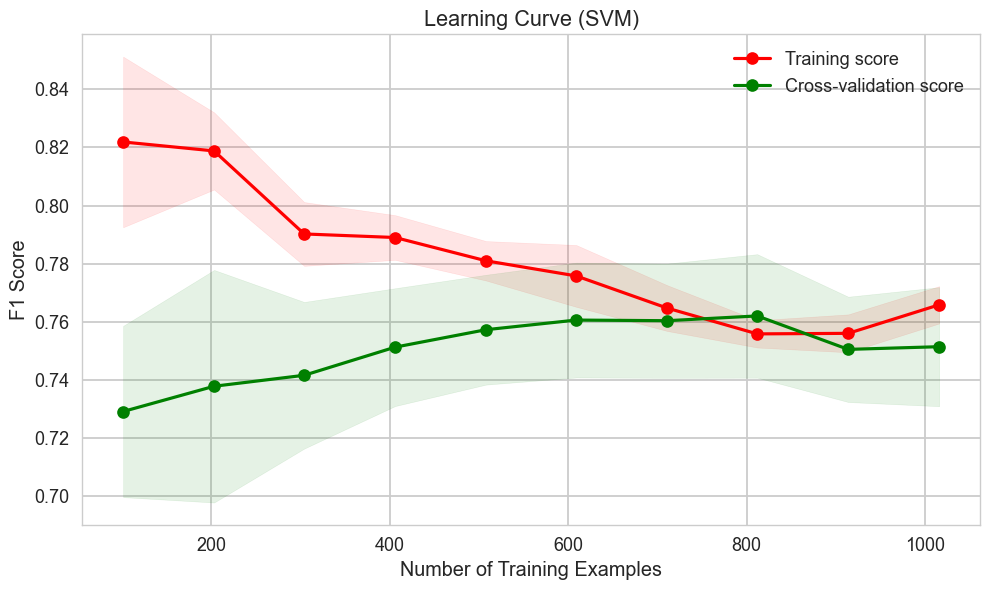


SVM analysis complete!


In [11]:
# --- Learning Curve --- 
# Generate learning curves for the best SVM model to understand bias/variance trade-off

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot generate learning curve.")
elif X.empty or y.empty:
     print("\nError: Full dataset (X, y) not available or empty. Cannot generate learning curve.")
else:
    print("\nGenerating learning curves for the best SVM pipeline...")
    # Generate data points for the learning curve
    train_sizes_abs, train_scores, test_scores = learning_curve(
        best_svm_pipeline, # The best estimator pipeline found
        X,                # Full feature set
        y,                # Full target variable
        cv=cv,            # Use the same cross-validation strategy
        n_jobs=-1,        # Use all available cores
        train_sizes=np.linspace(0.1, 1.0, 10), # Evaluate on 10 different training set sizes
        scoring='f1',     # Evaluate performance using F1 score
        random_state=42
    )
    
    # Calculate mean and standard deviation of scores across folds
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.style.use('seaborn-v0_8-whitegrid') # Apply a clean plot style
    plt.figure(figsize=(10, 6))
    
    # Plot shaded regions for standard deviation
    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot mean scores
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # Add plot labels and title
    plt.title("Learning Curve (SVM)")
    plt.xlabel("Number of Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('svm_learning_curve.png') # Save the plot
    plt.show()
    
    print("\nSVM analysis complete!")


## Conclusion

*TODO*